In [1]:
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General imports
import time
import math
import json
import requests
import functools as ft
import scipy.stats as stats

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# XGBoost and machine learning
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, PrecisionRecallDisplay, make_scorer
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA

# Hyperparameter tuning with Skopt
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
all_seasons = []

for season in range(2021, 2023):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023
      playerId    skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0      8465009       Zdeno Chara            D           72       12        0   
1      8466138      Joe Thornton            C           34        5        0   
2      8469455      Jason Spezza            C           71       13        0   
3      8470281      Duncan Keith            D           64       20        0   
4      8470595        Eric Staal            C           72       15        0   
...        ...               ...          ...          ...      ...      ...   
1136   8483808   Andrei Kuzmenko            L           81       35        2   
1137   8484125     Hunter McKown            C           12        2        0   
1138   8484254      Akito Hirose            D            7        3        0   
1139   8484256  Jake Livingstone            D            5        1        0   
1140   8484287       Cole 

In [3]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 60)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df.rename(columns={'timeOnIcePerGame': 'time_on_ice_per_game'}, inplace=True)
nhl_api_df['regulation_game_winning'] = nhl_api_df['game_winning_goals'] - nhl_api_df['ot_goals']

In [4]:
start_season = "20212022"
end_season = "20222023"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [5]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

In [6]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts', 'iCF', 'Rebounds Created']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 60]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)

In [7]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [8]:
merged_natural_stat

,Player,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,Rush Attempts,iCF,Rebounds Created
1,Jason Spezza,71,2,4,1,12,97,9.20,131,83,33,8,175,13
2,Eric Staal,72,3,2,3,14,106,12.99,142,119,65,8,183,17
3,Jeff Carter,155,8,7,6,32,339,37.53,429,317,168,24,555,63
4,Dustin Brown,64,1,2,2,9,146,15.64,196,129,65,6,238,12
5,Zach Parise,164,3,6,11,36,320,44.77,410,356,209,18,478,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,Matty Beniers,90,6,4,8,27,166,22.91,244,174,85,13,306,14
697,Cole Sillinger,143,3,5,6,19,241,27.17,338,276,115,7,433,36
700,Wyatt Johnston,82,4,4,8,24,160,18.92,207,192,94,8,281,35
701,Mason McTavish,89,2,6,5,19,173,22.67,231,174,92,8,285,35


In [9]:
nhl_api_df

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,time_on_ice_per_game,regulation_game_winning
0,8469455,Jason Spezza,C,71,13,0,1,644.76050,1
1,8470595,Eric Staal,C,72,15,0,1,854.22220,1
2,8470604,Jeff Carter,C,155,42,2,4,941.31485,2
3,8470606,Dustin Brown,R,64,19,0,0,884.34370,0
4,8470610,Zach Parise,L,164,33,1,6,942.90845,5
...,...,...,...,...,...,...,...,...,...
448,8482665,Matty Beniers,C,90,39,1,4,1020.96250,3
449,8482705,Cole Sillinger,C,143,23,0,3,810.29235,3
450,8482740,Wyatt Johnston,C,82,17,0,3,928.90240,3
451,8482745,Mason McTavish,C,89,27,0,2,853.62010,2


In [10]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [11]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,time_on_ice_per_game,regulation_game_winning,GP,...,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,Rush Attempts,iCF,Rebounds Created
0,8469455,Jason Spezza,C,71,13,0,1,644.76050,1,71.0,...,1.0,12.0,97.0,9.20,131.0,83.0,33.0,8.0,175.0,13.0
1,8470595,Eric Staal,C,72,15,0,1,854.22220,1,72.0,...,3.0,14.0,106.0,12.99,142.0,119.0,65.0,8.0,183.0,17.0
2,8470604,Jeff Carter,C,155,42,2,4,941.31485,2,155.0,...,6.0,32.0,339.0,37.53,429.0,317.0,168.0,24.0,555.0,63.0
3,8470606,Dustin Brown,R,64,19,0,0,884.34370,0,64.0,...,2.0,9.0,146.0,15.64,196.0,129.0,65.0,6.0,238.0,12.0
4,8470610,Zach Parise,L,164,33,1,6,942.90845,5,164.0,...,11.0,36.0,320.0,44.77,410.0,356.0,209.0,18.0,478.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,8482665,Matty Beniers,C,90,39,1,4,1020.96250,3,90.0,...,8.0,27.0,166.0,22.91,244.0,174.0,85.0,13.0,306.0,14.0
449,8482705,Cole Sillinger,C,143,23,0,3,810.29235,3,143.0,...,6.0,19.0,241.0,27.17,338.0,276.0,115.0,7.0,433.0,36.0
450,8482740,Wyatt Johnston,C,82,17,0,3,928.90240,3,82.0,...,8.0,24.0,160.0,18.92,207.0,192.0,94.0,8.0,281.0,35.0
451,8482745,Mason McTavish,C,89,27,0,2,853.62010,2,89.0,...,5.0,19.0,173.0,22.67,231.0,174.0,92.0,8.0,285.0,35.0


In [12]:
null_rows = merged_clutch_goals[merged_clutch_goals.isnull().any(axis=1)]
merged_clutch_goals = merged_clutch_goals.fillna(0)
print("Rows with null values:")
print(null_rows)

Rows with null values:
     playerId            Player positionCode  gamesPlayed  assists  ot_goals  \
168   8477073  Kurtis MacDermid            L          102        8         0   

     game_winning_goals  time_on_ice_per_game  regulation_game_winning  GP  \
168                   1                471.94                        1 NaN   

     ...  goals_when_tied  total_goals  shots  ixG  iFF  iSCF  iHDCF  \
168  ...              NaN          NaN    NaN  NaN  NaN   NaN    NaN   

     Rush Attempts  iCF  Rebounds Created  
168            NaN  NaN               NaN  

[1 rows x 22 columns]


In [13]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)

In [14]:
columns = ['ot_goals', 'regulation_game_winning', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'Rebounds Created']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


In [15]:
merged_clutch_goals['clutch_score'] = 0.3 * merged_clutch_goals['goals_when_tied_per_game'] + 0.3 * merged_clutch_goals['goals_down_by_one_per_game'] + 0.2 * merged_clutch_goals['goals_up_by_one_per_game'] + 0.1 * merged_clutch_goals['regulation_game_winning_per_game'] + 0.1 * merged_clutch_goals['ot_goals_per_game']

In [16]:
merged_clutch_goals['clutch_score'] *= 100
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
229,David Pastrnak,14.61,1.0
305,Auston Matthews,13.67,2.0
258,Connor McDavid,13.64,3.0
216,Leon Draisaitl,13.56,4.0
293,Kirill Kaprizov,12.43,5.0
370,Josh Norris,12.16,6.0
365,Jason Robertson,11.99,7.0
332,Tage Thompson,11.92,8.0
421,Jack Hughes,11.57,9.0
149,Filip Forsberg,11.18,10.0


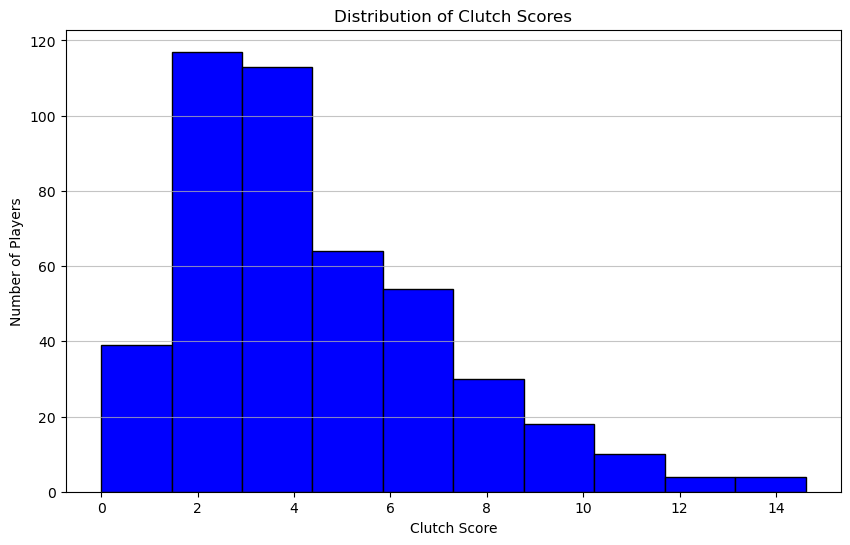

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Clutch Score")
plt.ylabel("Number of Players")
plt.title("Distribution of Clutch Scores")
plt.show()

In [18]:
threshold_elite = merged_clutch_goals['clutch_score'].quantile(0.85)
threshold_high = merged_clutch_goals['clutch_score'].quantile(0.7)
threshold_average = merged_clutch_goals['clutch_score'].quantile(0.5)


def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold_elite:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

In [19]:
merged_clutch_goals['clutch_label'].value_counts()

clutch_label
0    385
1     68
Name: count, dtype: int64

In [20]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game','time_on_ice_per_game']
y_var = 'clutch_label'

X = merged_clutch_goals[x_var]
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [21]:
skf = StratifiedKFold(n_splits=10)

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

scores = cross_validate(xgb_model, X, y, cv = skf, scoring = scoring)

df_scores = pd.DataFrame.from_dict(scores)

df_scores.mean()

fit_time          0.183268
score_time        0.017698
test_accuracy     0.899082
test_precision    0.825108
test_recall       0.671429
test_f1           0.682806
dtype: float64

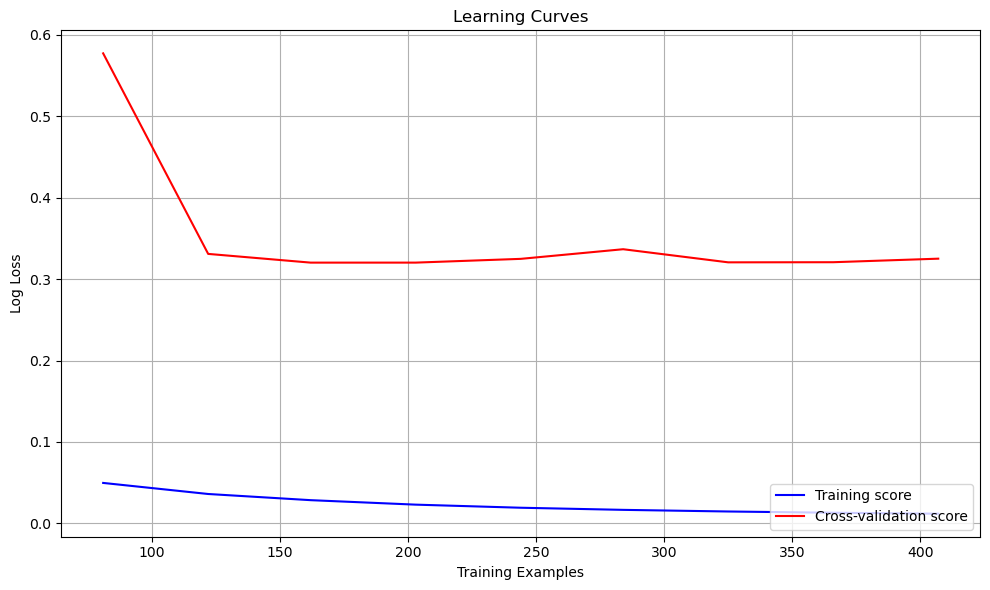

In [22]:
cv = StratifiedKFold(n_splits=10)

train_sizes = np.linspace(0.1, 1.0, 10)
    
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss',
)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

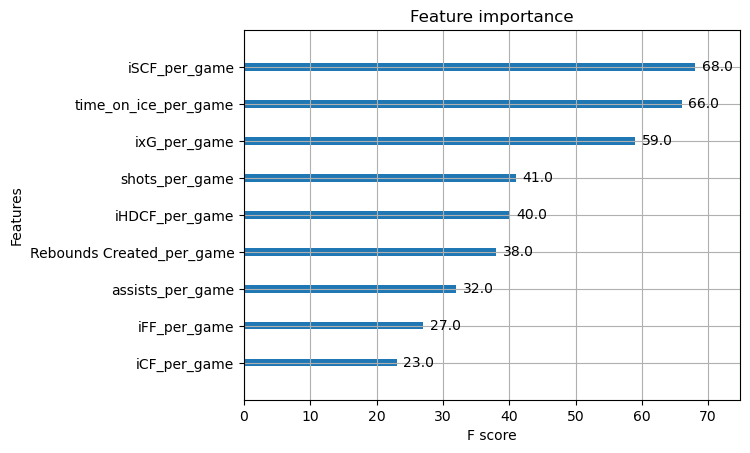

In [23]:
plot_importance(xgb_model)
plt.show()

In [24]:
x_var_adjusted = ['shots_per_game', 'ixG_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals[x_var_adjusted]

In [25]:
param_grid = {
    'max_depth': Integer(2,5),
    'min_child_weight': Integer(2,3), 
    'n_estimators': Integer(200, 300),
    'learning_rate': Real(0.03, 0.04), 
    'reg_alpha': Real(0.75, 1.9),
    'reg_lambda': Real(0.75, 1.9),
    'subsample': Real(0.7, 1), 
    'colsample_bytree': Real(0.7, 1)  
}

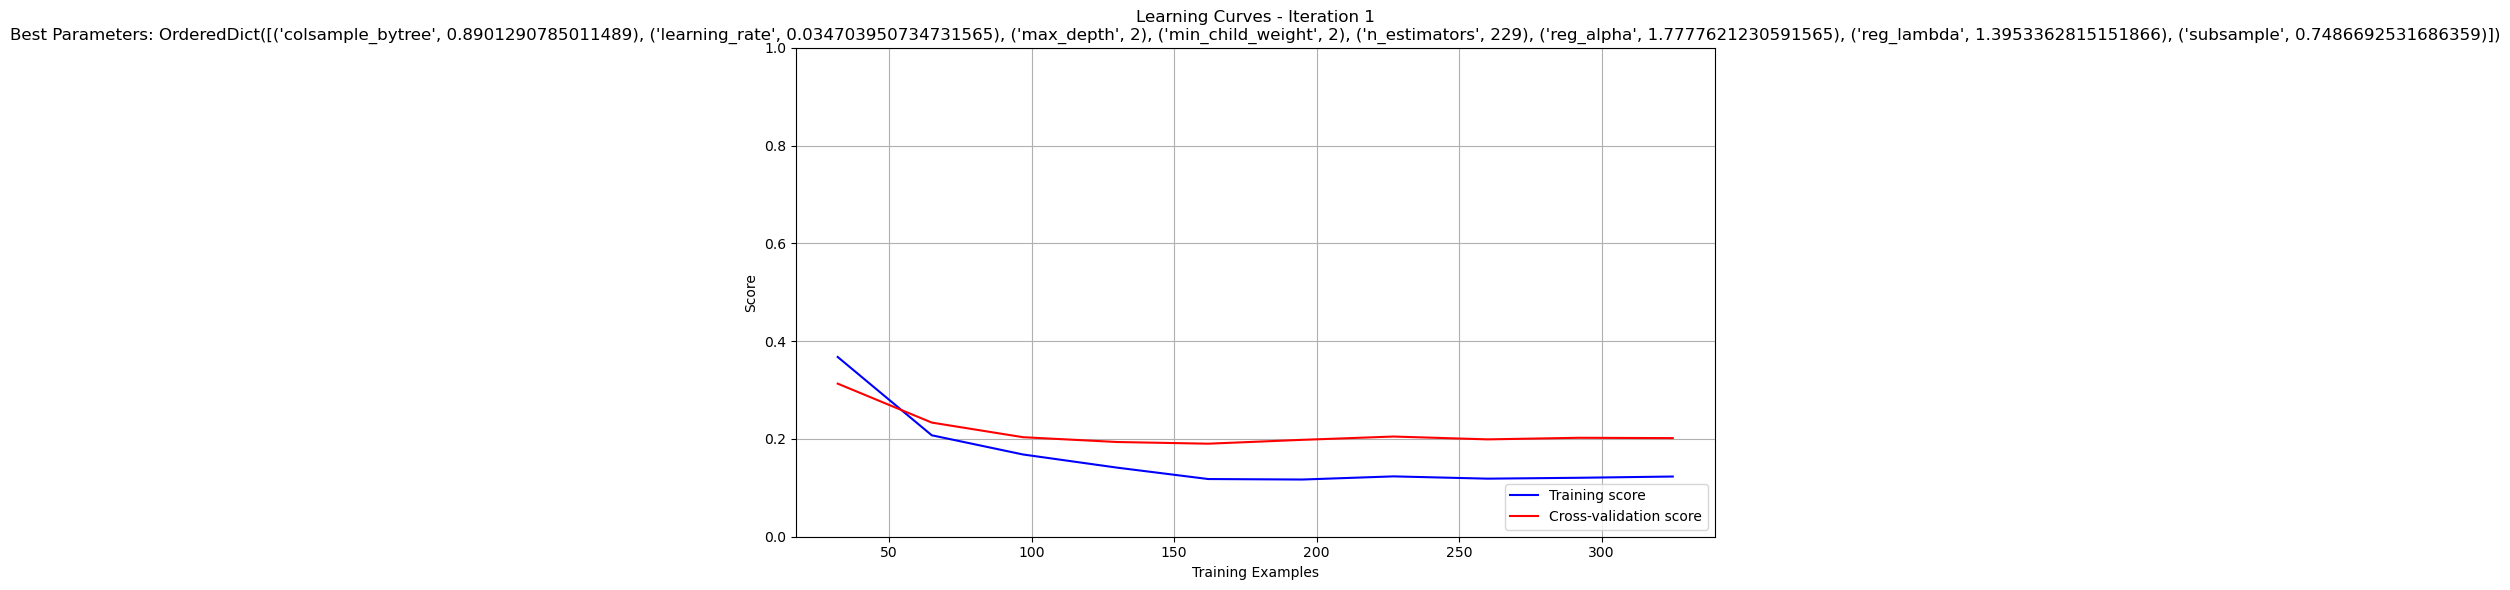

Recall Score:  1.0


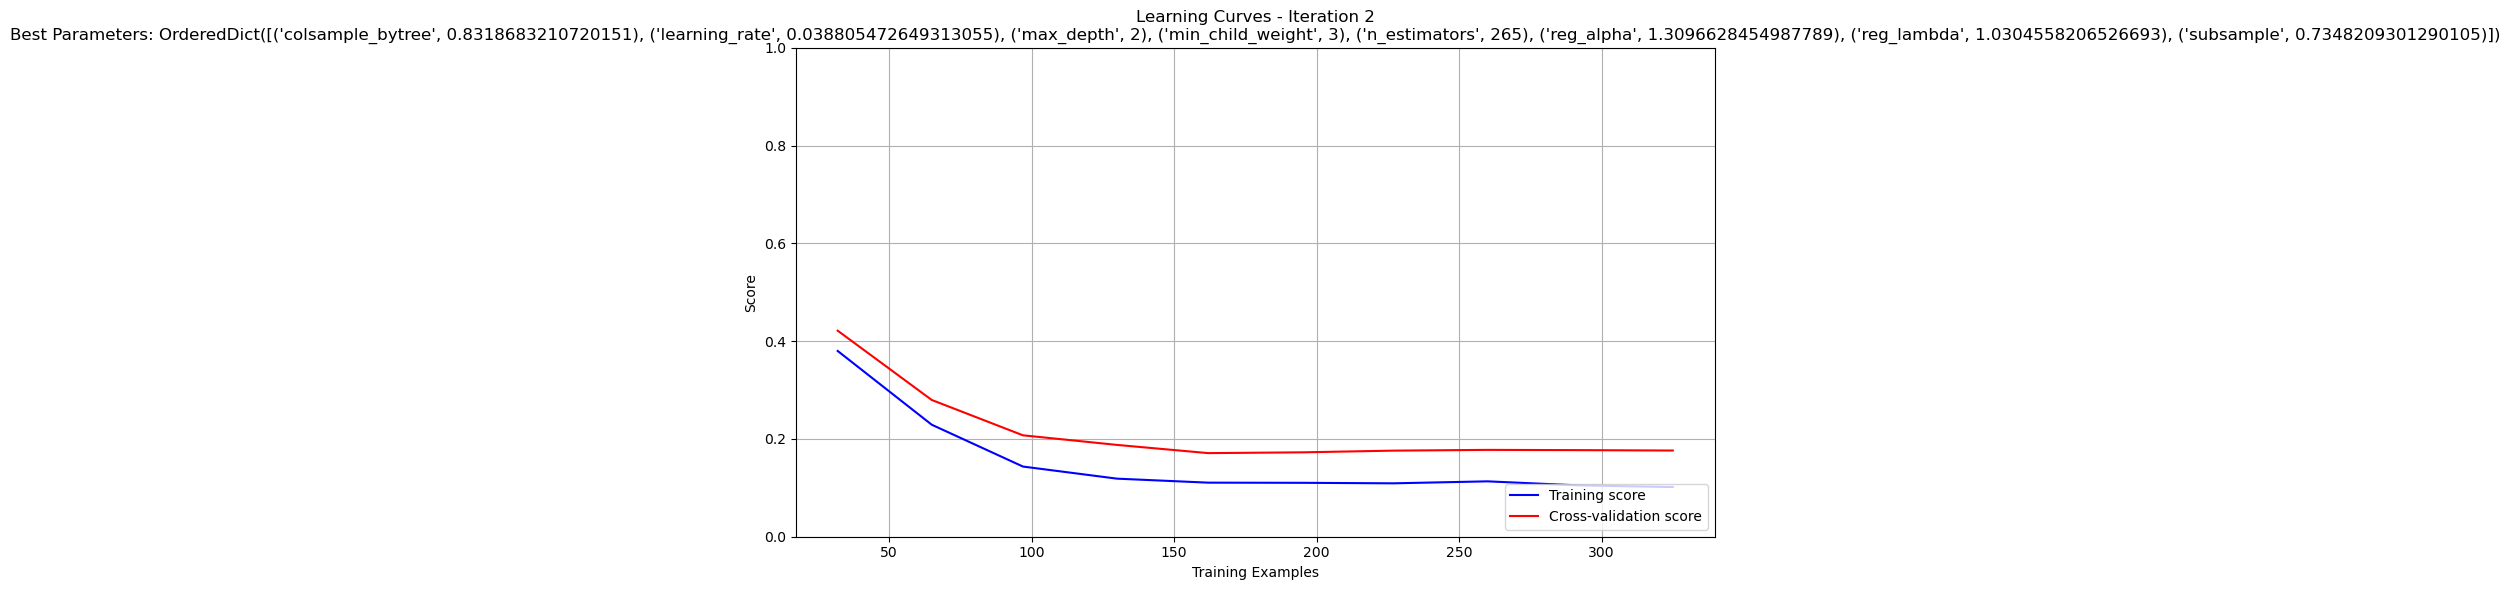

Recall Score:  0.6428571428571429
Average Accuracy: 0.9615384615384615
Average Precision: 0.9375
Average Recall: 0.8214285714285714
Average F1 Score: 0.8579710144927537
Averaged Hyperparameters:
colsample_bytree      0.860999
learning_rate         0.036755
max_depth             2.000000
min_child_weight      2.500000
n_estimators        247.000000
reg_alpha             1.543712
reg_lambda            1.212896
subsample             0.741745
dtype: float64


In [26]:
cv = StratifiedKFold(n_splits=10)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
best_hyperparams_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


for _ in range(2):
    rs = np.random.randint(1, 1000)

    train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state = rs
    )

    class_weights = compute_sample_weight(class_weight='balanced', y=train_y)
    
    xgb_model_adjusted = xgb.XGBClassifier(n_estimators = 100, eval_metric = 'logloss')
    xgb_model_adjusted.fit(train_x, train_y, sample_weight = class_weights)

    random_search = BayesSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, scoring= ['recall'], refit='recall', n_jobs = -1)

    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_
    
    title = f'Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, train_x, train_y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  

    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, zero_division=0)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)

    print("Recall Score: ", recall)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    best_hyperparams_list.append(random_search.best_params_)

print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.median(recall_list))
print("Average F1 Score:", np.mean(f1_list))

hyperparams_df = pd.DataFrame(best_hyperparams_list)
averaged_hyperparams = hyperparams_df.mean()
print("Averaged Hyperparameters:")
print(averaged_hyperparams)

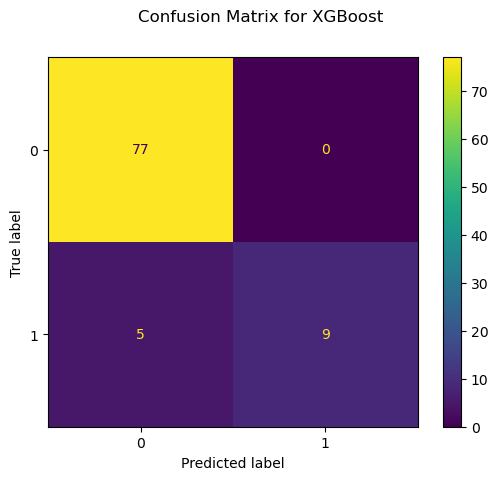

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(test_y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [28]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X= merged_clutch_goals[x_var]
y_var = 'clutch_score'  
y = merged_clutch_goals[y_var]

correlation = X.corrwith(y) 
print(correlation)

shots_per_game               0.869740
ixG_per_game                 0.877087
iFF_per_game                 0.873166
iSCF_per_game                0.889191
iHDCF_per_game               0.723217
assists_per_game             0.748811
iCF_per_game                 0.865429
Rebounds Created_per_game    0.758342
time_on_ice_per_game         0.780655
dtype: float64


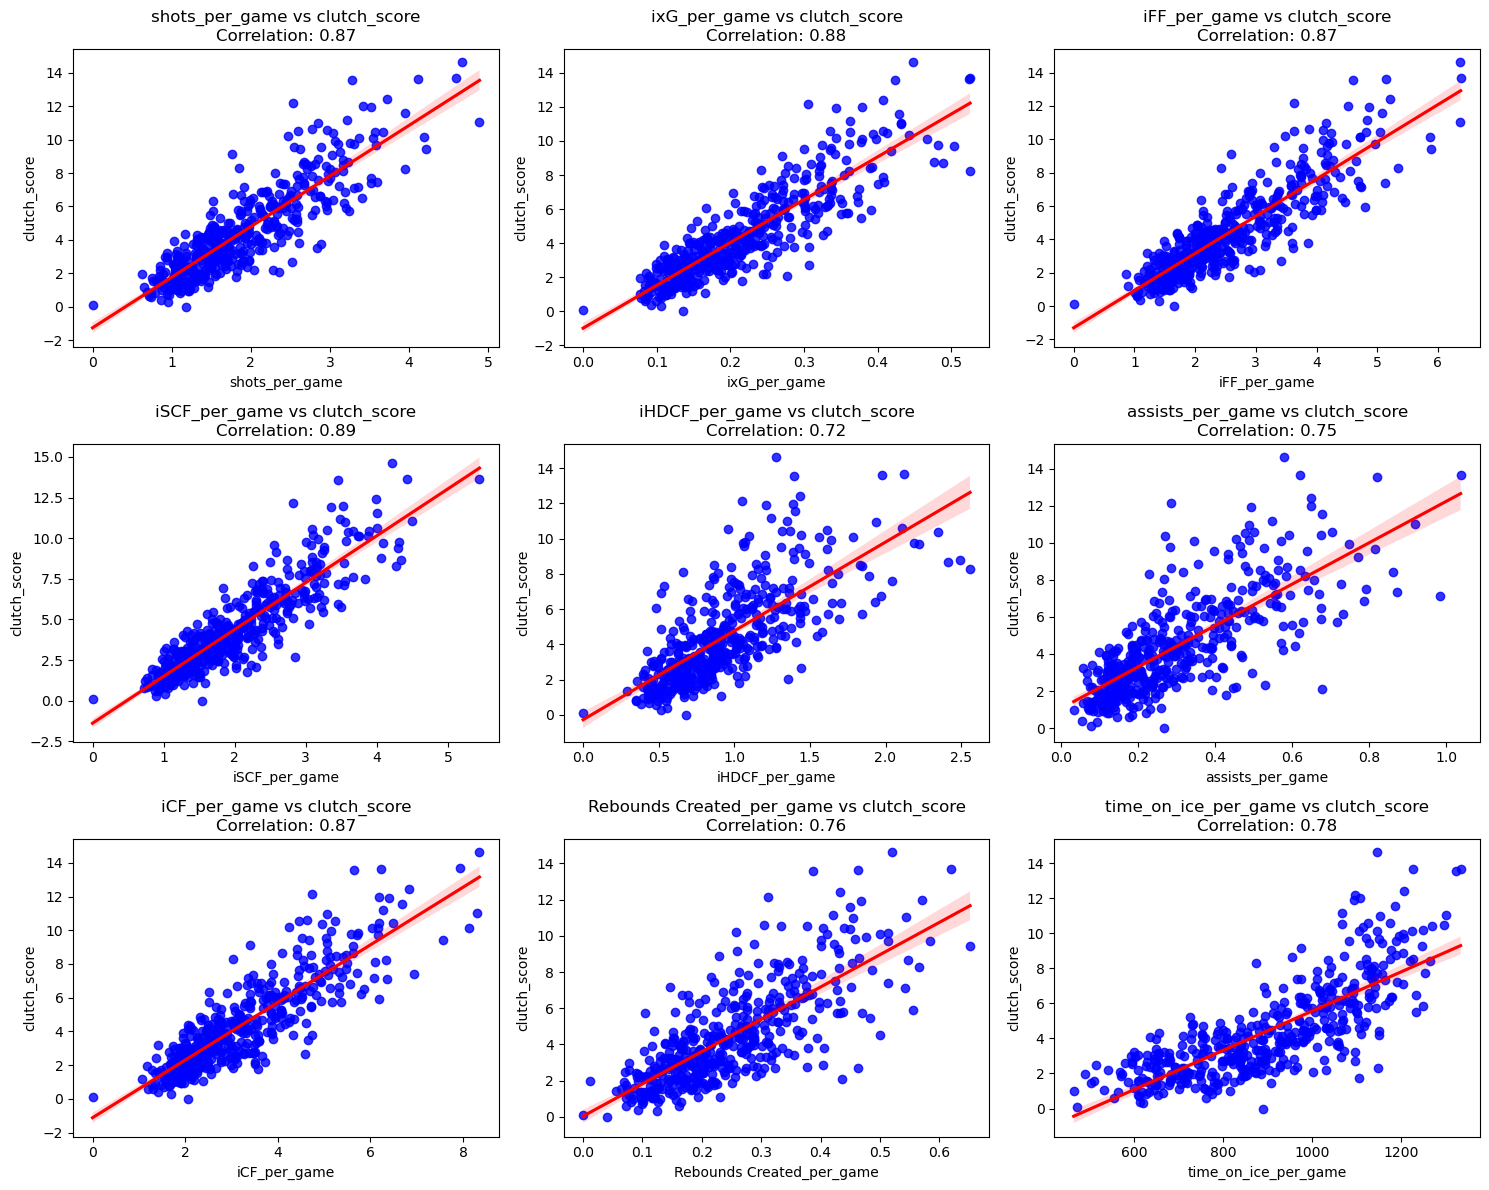

In [29]:
plt.figure(figsize=(15, 12))  

for i, var in enumerate(x_var):
    plt.subplot(3, 3, i+1)
    
    sns.regplot(data=merged_clutch_goals, x=var, y=y, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    
    plt.title(f'{var} vs {y_var}\nCorrelation: {correlation[var]:.2f}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel(y_var)

plt.tight_layout()  
plt.show()

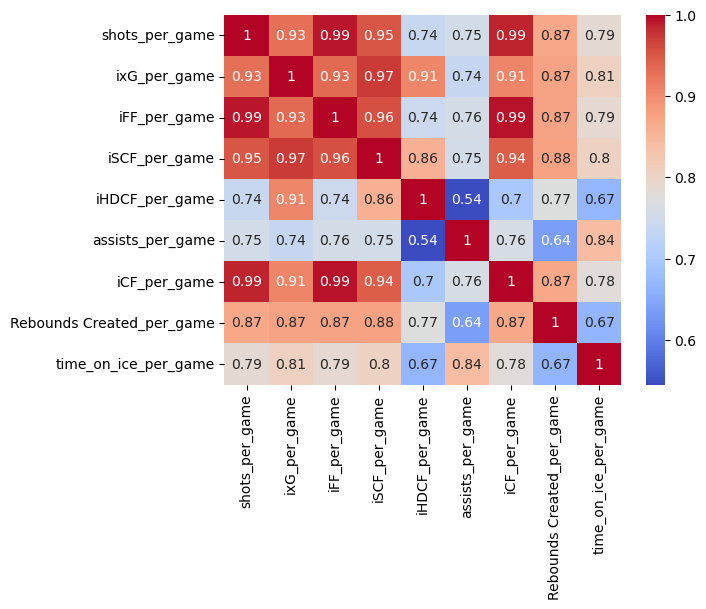

In [30]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

In [31]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals[y_var]

X_scaled = StandardScaler().fit_transform(X_adjusted)

train_x, test_x, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

alphas_random = np.random.uniform(0.0001, 1000, 50)

ridge_cv = RidgeCV(alphas=alphas_random, store_cv_values=True)
ridge_cv.fit(train_x, train_y)

y_pred = ridge_cv.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))

MSE:  1.152474467367837
RMSE:  1.0735336358809802
MAE:  0.6364247233345224
R²:  0.8679880512482763
Adjusted R²:  0.8646127457404197


In [32]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, validation_scores = learning_curve(
ridge_cv,
X_scaled,
y, train_sizes = train_sizes, cv = 10,
scoring = 'neg_mean_squared_error')


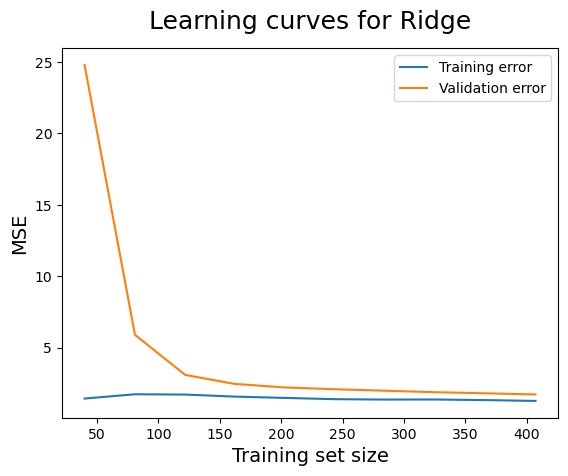

In [33]:
import matplotlib.pyplot as plt

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Ridge', fontsize = 18, y = 1.03)
plt.legend()

In [34]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(60))

All predictions and actual values:
                    Player  Actual  Predicted     Error
229         David Pastrnak   14.61  11.307523  3.302477
3             Dustin Brown    2.19   4.930351  2.740351
442          Cole Perfetti    2.03   4.562734  2.532734
149         Filip Forsberg   11.18   8.652988  2.527012
265          Sebastian Aho   10.97   8.513738  2.456262
101        Mikael Granlund    2.33   4.587530  2.257530
217            Sam Bennett    5.75   7.908011  2.158011
239         Michael Amadio    4.31   2.199782  2.110218
16           Sidney Crosby    9.93   7.982018  1.947982
240       Viktor Arvidsson    6.22   8.096395  1.876395
32             Phil Kessel    2.74   4.452673  1.712673
312         Clayton Keller    8.52   6.829200  1.690800
102      Nino Niederreiter    6.86   5.218497  1.641503
211        Garnet Hathaway    4.06   2.527352  1.532648
134        Phillip Danault    6.89   5.477753  1.412247
376      Fabian Zetterlund    2.72   4.033620  1.313620
277    Anthon

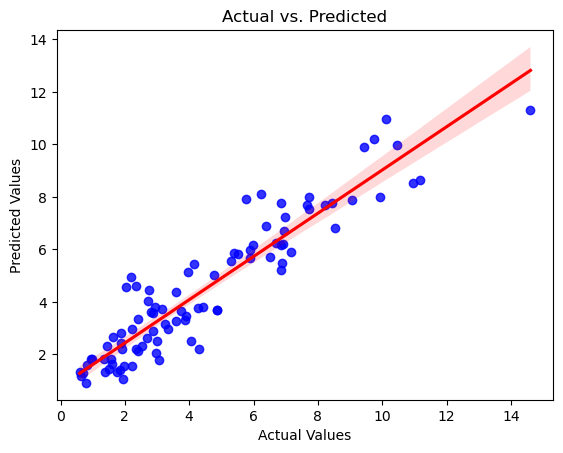

In [35]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

<Axes: xlabel='clutch_score'>

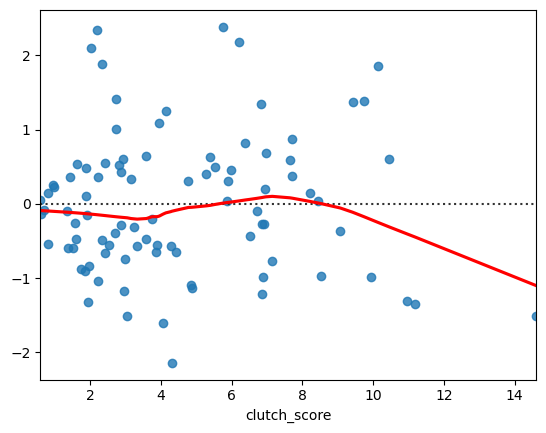

In [36]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))

There are 43 influential points.
Outliers based on Cook's Distance:
                Player  Actual  Predicted  Cook's Distance
229     David Pastrnak   14.61  11.394353         0.057417
258     Connor McDavid   13.64  12.624625         0.012062
216     Leon Draisaitl   13.56  10.145268         0.048917
293    Kirill Kaprizov   12.43  10.326914         0.009470
370        Josh Norris   12.16   7.124885         0.061732
365    Jason Robertson   11.99   8.848763         0.041672
332      Tage Thompson   11.92   8.202728         0.028355
149     Filip Forsberg   11.18   8.708238         0.021716
265      Sebastian Aho   10.97   8.700919         0.013163
238      Brayden Point   10.61   9.146815         0.012707
49      Steven Stamkos   10.56   8.566349         0.011626
274        Roope Hintz   10.52   7.958906         0.009590
71       Chris Kreider   10.38   7.941338         0.028399
130     Mark Scheifele   10.20   7.938822         0.012459
10       Alex Ovechkin   10.13  11.375787      

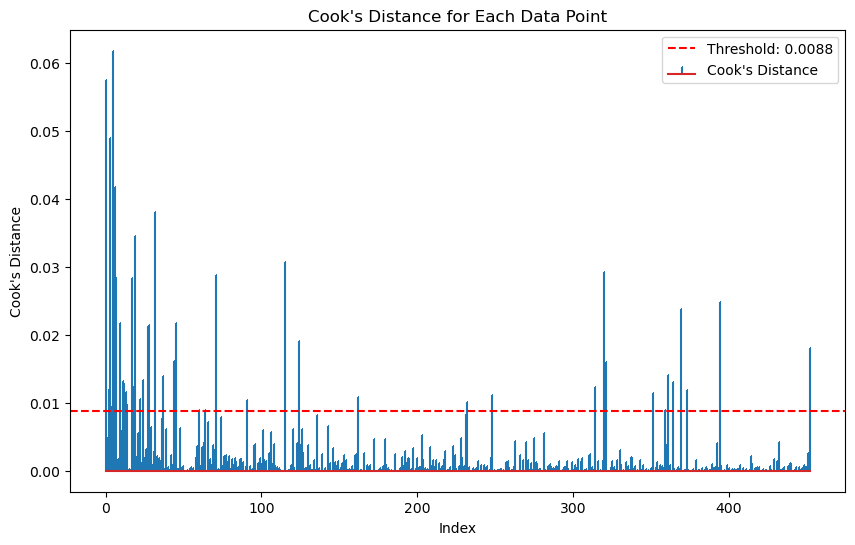

In [37]:
X_with_intercept = sm.add_constant(X_scaled)

ols_model = sm.OLS(y, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()


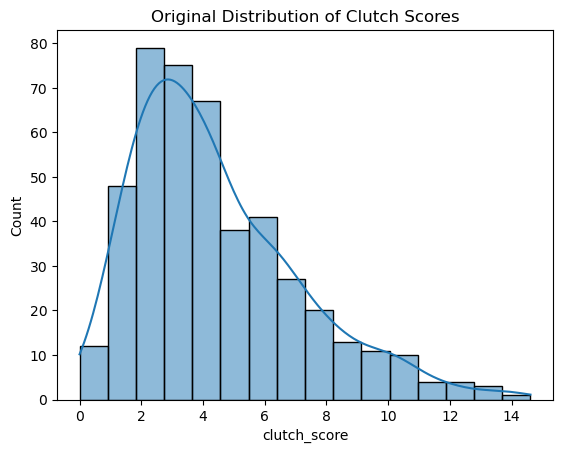

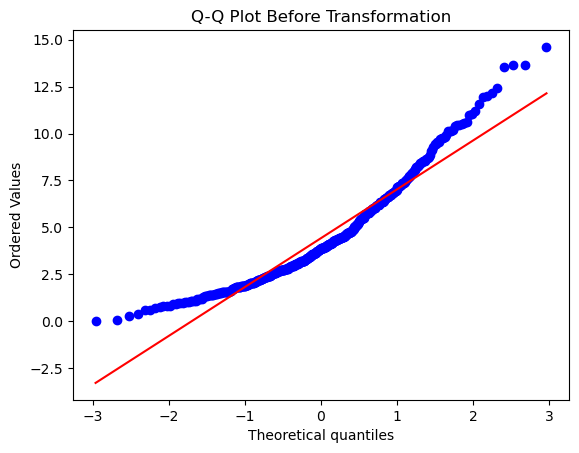

In [38]:
sns.histplot(y, kde=True)
plt.title("Original Distribution of Clutch Scores")
plt.show()

stats.probplot(y, dist="norm", plot=plt)
plt.title("Q-Q Plot Before Transformation")
plt.show()

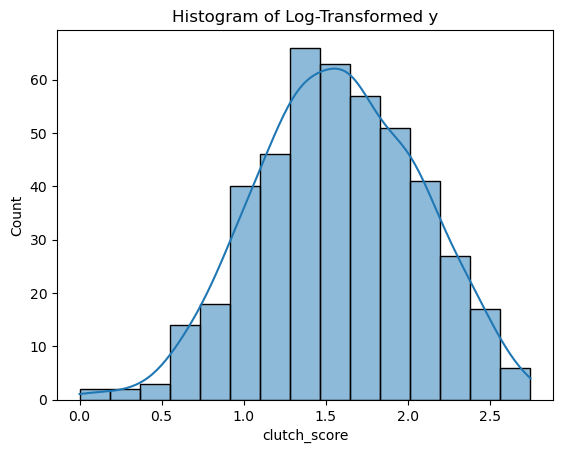

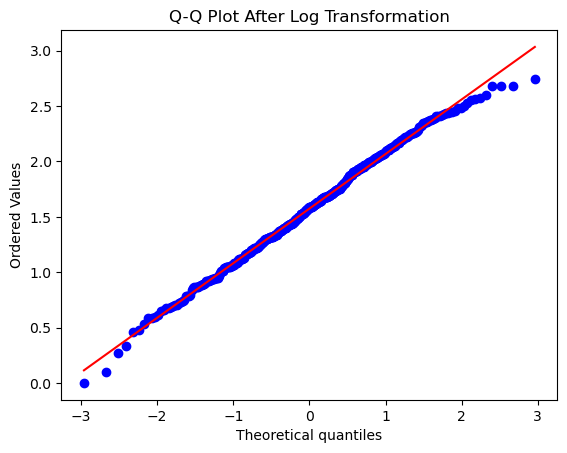

In [39]:
y_log = np.log(y + 1)  

sns.histplot(y_log, kde=True)
plt.title("Histogram of Log-Transformed y")
plt.show()

stats.probplot(y_log, dist="norm", plot=plt)
plt.title("Q-Q Plot After Log Transformation")
plt.show()

In [40]:
epsilon = np.abs(X_scaled.min()) + 1

X_shifted = X_scaled + epsilon

In [41]:
y_log = np.log(y + 1)

X_log = np.log(X_shifted)

train_x, test_x, train_y, test_y = train_test_split(
    X_log, 
    y_log, 
    test_size=0.2, 
    random_state=42
)

alphas_random = np.random.uniform(0.0001, 1000, 50)
ridge_cv_log = RidgeCV(alphas=alphas_random, store_cv_values=True)
ridge_cv_log.fit(train_x, train_y)
y_pred = ridge_cv_log.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))


MSE:  0.04693362096981804
RMSE:  0.21664168797767902
MAE:  0.13062631964853022
R²:  0.8407088436512774
Adjusted R²:  0.8366360584037249


In [42]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(55))

All predictions and actual values:
                  Player    Actual  Predicted     Error
3           Dustin Brown  1.160021   1.724263  0.564242
7          Loui Eriksson  0.598837   1.084934  0.486097
446            Nils Aman  0.463734   0.943424  0.479690
442        Cole Perfetti  1.108563   1.574102  0.465539
239       Michael Amadio  1.669592   1.221453  0.448139
101      Mikael Granlund  1.202972   1.643975  0.441003
161     Dominic Toninato  1.081805   0.664525  0.417280
95         Riley Sheahan  0.530628   0.913371  0.382743
211      Garnet Hathaway  1.621366   1.242101  0.379266
294        Dominik Simon  0.678034   1.041366  0.363332
385         Parker Kelly  0.662688   1.012744  0.350056
269          Tommy Novak  1.769855   1.425392  0.344463
32           Phil Kessel  1.319086   1.654046  0.334960
159        Teddy Blueger  0.970779   1.304176  0.333397
266    Evgeny Svechnikov  1.398717   1.075724  0.322993
337        Brandon Hagel  2.098018   1.778214  0.319804
153          

There are 14 influential points.
Outliers based on Cook's Distance:
                Player    Actual  Predicted  Cook's Distance
370        Josh Norris  2.577182   2.035968         0.015041
452    Andrei Kuzmenko  2.316488   1.817834         0.015647
345         Mason Shaw  1.401183   1.031138         0.019759
106  Brendan Gallagher  1.305626   1.919457         0.021439
3         Dustin Brown  1.160021   1.702659         0.014397
46       Jakub Voracek  1.134623   1.487096         0.013261
22    Patric Hornqvist  1.121678   1.698192         0.034031
442      Cole Perfetti  1.108563   1.615660         0.014665
161   Dominic Toninato  1.081805   0.780806         0.015343
165       Connor Brown  1.015231   1.750591         0.025766
441    Quinton Byfield  0.732368   1.292210         0.020188
446          Nils Aman  0.463734   0.945224         0.017715
174    Saku Maenalanen  0.270027   0.874958         0.014503
104     Joonas Donskoi  0.000000   1.332488         0.170874


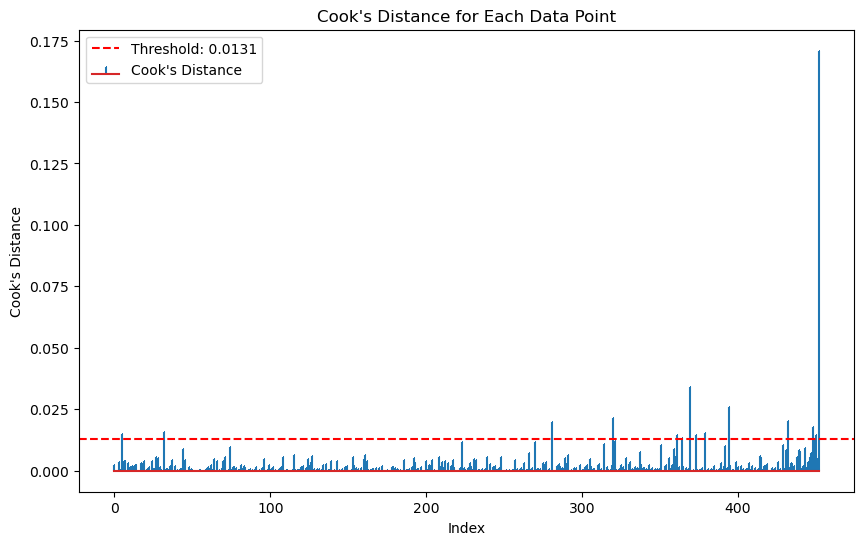

In [43]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / (316-9-1)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

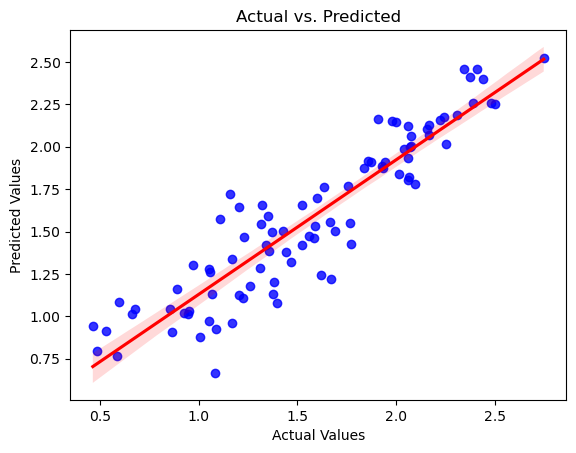

In [44]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

<Axes: xlabel='clutch_score'>

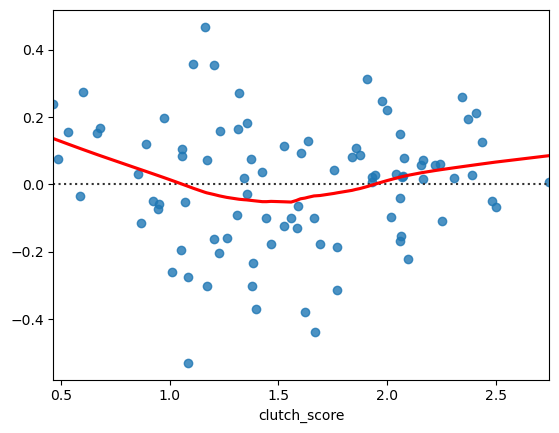

In [45]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))

In [47]:
all_seasons = []

for season in range(2023, 2025):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2023-2024
Successfully fetched data for season 2024-2025
     playerId      skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0     8470600          Ryan Suter            D           97       18        0   
1     8470604         Jeff Carter            C           72        4        0   
2     8470610         Zach Parise            L           30        5        0   
3     8470613         Brent Burns            D           96       38        0   
4     8470621         Corey Perry            R           69       11        0   
..        ...                 ...          ...          ...      ...      ...   
954   8484779       Jett Luchanko            C            4        0        0   
955   8484801   Macklin Celebrini            C            5        1        0   
956   8484911         Collin Graf            R            7        2        0   
957   8484958     Maxim Tsyplakov            R           15        7        0   
958   8485105  

In [48]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 30)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df.rename(columns={'timeOnIcePerGame': 'time_on_ice_per_game'}, inplace=True)
nhl_api_df['regulation_game_winning'] = nhl_api_df['game_winning_goals'] - nhl_api_df['ot_goals']

In [49]:
start_season = "20232024"
end_season = "20242025"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [50]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

In [51]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts', 'iCF', 'Rebounds Created']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 30]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)

In [52]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [53]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [54]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)

In [55]:
columns = ['ot_goals', 'regulation_game_winning', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'Rebounds Created']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']

In [56]:
merged_clutch_goals['clutch_score'] = 0.3 * merged_clutch_goals['goals_when_tied_per_game'] + 0.3 * merged_clutch_goals['goals_down_by_one_per_game'] + 0.2 * merged_clutch_goals['goals_up_by_one_per_game'] + 0.1 * merged_clutch_goals['regulation_game_winning_per_game'] + 0.1 * merged_clutch_goals['ot_goals_per_game']

In [57]:
merged_clutch_goals['clutch_score'] *= 100
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
260,Auston Matthews,16.49,1.0
175,Sam Reinhart,15.46,2.0
189,David Pastrnak,12.96,3.0
249,Kirill Kaprizov,12.78,4.0
244,Artemi Panarin,12.32,5.0
176,Leon Draisaitl,12.08,6.0
213,Kyle Connor,11.88,7.0
197,Brayden Point,11.61,8.0
93,Nikita Kucherov,11.47,9.0
182,Dylan Larkin,11.34,10.0


In [58]:
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
260,Auston Matthews,16.49,1.0
175,Sam Reinhart,15.46,2.0
189,David Pastrnak,12.96,3.0
249,Kirill Kaprizov,12.78,4.0
244,Artemi Panarin,12.32,5.0
176,Leon Draisaitl,12.08,6.0
213,Kyle Connor,11.88,7.0
197,Brayden Point,11.61,8.0
93,Nikita Kucherov,11.47,9.0
182,Dylan Larkin,11.34,10.0


In [59]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals[y_var]

In [60]:
merged_clutch_goals = merged_clutch_goals.fillna(0)

X_scaled = StandardScaler().fit_transform(X_adjusted)
X_scaled = np.nan_to_num(X_scaled, nan=0)

epsilon = np.abs(X_scaled.min()) + 1

X_shifted = X_scaled + epsilon

y_log = np.log(y + 1)

X_log = np.log(X_shifted)

y_pred = ridge_cv_log.predict(X_log)

In [61]:
merged_clutch_goals['predicted_clutch_score'] = y_pred
merged_clutch_goals['log'] = np.log(merged_clutch_goals['clutch_score'] + 1) 
merged_clutch_goals['predicted_clutch_score_rank']  = merged_clutch_goals['predicted_clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals.sort_values('predicted_clutch_score_rank', inplace = True)

In [62]:
merged_clutch_goals[['Player', 'predicted_clutch_score_rank', 'clutch_score_rank', 'predicted_clutch_score', 'log']].head(20)

,Player,predicted_clutch_score_rank,clutch_score_rank,predicted_clutch_score,log
260,Auston Matthews,1.0,1.0,2.737774,2.861629
156,Nathan MacKinnon,2.0,13.0,2.676233,2.460443
189,David Pastrnak,3.0,3.0,2.616205,2.636196
249,Kirill Kaprizov,4.0,4.0,2.597986,2.623218
340,Brady Tkachuk,5.0,34.0,2.596146,2.318458
139,Jake Guentzel,6.0,87.0,2.590442,2.020222
380,Jack Hughes,7.0,27.0,2.552578,2.351375
93,Nikita Kucherov,8.0,9.0,2.547508,2.523326
118,Filip Forsberg,9.0,11.0,2.544505,2.503074
71,Zach Hyman,10.0,36.0,2.538490,2.297573


In [ ]:
y_log = np.log(y + 1)  

sns.histplot(y_log, kde=True)
plt.title("Histogram of Log-Transformed y")
plt.show()

stats.probplot(y_log, dist="norm", plot=plt)
plt.title("Q-Q Plot After Log Transformation")
plt.show()

In [120]:
X_scaled = StandardScaler().fit_transform(X_adjusted)

epsilon = np.abs(X_scaled.min()) + 1

y_log = np.log(y + 1)

y_log = y_log.fillna(0)

X_log = np.log(X_shifted)

train_x, test_x, train_y, test_y = train_test_split(
    X_log, 
    y_log, 
    test_size=0.2, 
    random_state=42
)

alphas_random = np.random.uniform(0.0001, 1000, 50)
ridge_cv_log = RidgeCV(alphas=alphas_random, store_cv_values=True)
ridge_cv_log.fit(train_x, train_y)
y_pred = ridge_cv_log.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))

MSE:  0.15261896226760596
RMSE:  0.3906647696780527
MAE:  0.21445155632018176
R²:  0.6655513780745999
Adjusted R²:  0.656951270653661
